Epoch [1/50] | Train Loss: 0.290282 | Val Loss: 0.042751
Epoch [2/50] | Train Loss: 0.119889 | Val Loss: 0.055088
Epoch [3/50] | Train Loss: 0.061540 | Val Loss: 0.047790
Epoch [4/50] | Train Loss: 0.056029 | Val Loss: 0.044460
Epoch [5/50] | Train Loss: 0.046353 | Val Loss: 0.033554
Epoch [6/50] | Train Loss: 0.044093 | Val Loss: 0.032425
Epoch [7/50] | Train Loss: 0.044583 | Val Loss: 0.032435
Epoch [8/50] | Train Loss: 0.043270 | Val Loss: 0.033736
Epoch [9/50] | Train Loss: 0.041887 | Val Loss: 0.032433
Epoch [10/50] | Train Loss: 0.041890 | Val Loss: 0.032062
Epoch [11/50] | Train Loss: 0.040818 | Val Loss: 0.032618
Epoch [12/50] | Train Loss: 0.041974 | Val Loss: 0.032241
Epoch [13/50] | Train Loss: 0.041986 | Val Loss: 0.032529
Epoch [14/50] | Train Loss: 0.041525 | Val Loss: 0.032035
Epoch [15/50] | Train Loss: 0.042033 | Val Loss: 0.031813
Epoch [16/50] | Train Loss: 0.040470 | Val Loss: 0.031939
Epoch [17/50] | Train Loss: 0.041477 | Val Loss: 0.032378
Epoch [18/50] | Train L

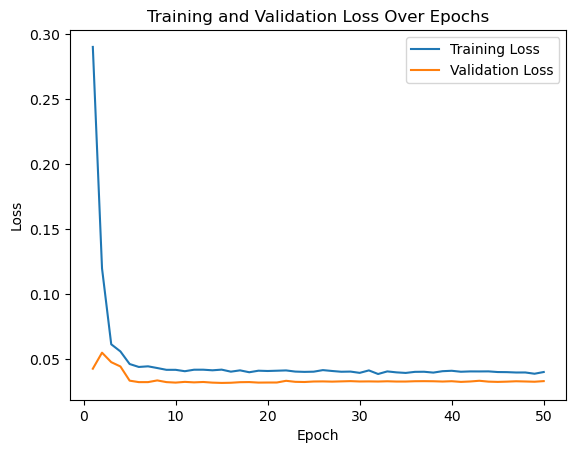

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from typing import Tuple, List

def batch_generator(train_x: np.ndarray, train_y: np.ndarray, batch_size: int):
    """
    Generator that yields mini-batches of data from the training set.

    This helps in iterating over the training data in batches, which is useful for
    mini-batch stochastic gradient descent.

    :param train_x: Input features array of shape (n_samples, n_features).
    :param train_y: Target values array of shape (n_samples, n_outputs).
    :param batch_size: Number of samples per batch.
    :yield: A tuple (batch_x, batch_y) for each batch.
    """
    n = train_x.shape[0]
    for start_idx in range(0, n, batch_size):
        end_idx = start_idx + batch_size
        batch_x = train_x[start_idx:end_idx]
        batch_y = train_y[start_idx:end_idx]
        yield batch_x, batch_y


##############################################################################################################################
#                                               Activation Functions (Abstract Base Class)                                 #
##############################################################################################################################

class ActivationFunction(ABC):
    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Compute the activation function for the given input.
        
        :param x: Input array.
        :return: Activated output.
        """
        pass

    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Compute the derivative of the activation function with respect to the input.
        
        :param x: Input array.
        :return: Derivative of the activation function evaluated at x.
        """
        pass


class Sigmoid(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Compute the sigmoid activation: 1 / (1 + exp(-x))."""
        return 1.0 / (1.0 + np.exp(-x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Compute the derivative of the sigmoid function.
        
        The derivative is: sigmoid(x) * (1 - sigmoid(x)).
        """
        sig = self.forward(x)
        return sig * (1.0 - sig)


class Tanh(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Compute the hyperbolic tangent activation."""
        return np.tanh(x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Compute the derivative of the tanh function.
        
        The derivative is: 1 - tanh(x)^2.
        """
        return 1.0 - np.tanh(x)**2


class Relu(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Compute the ReLU activation: max(0, x)."""
        return np.maximum(0, x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Compute the derivative of the ReLU function.
        
        The derivative is 1 for x > 0 and 0 otherwise.
        """
        return (x > 0).astype(x.dtype)


class Softmax(ActivationFunction):
    """
    Softmax activation is generally used in the final layer for multi-class classification.
    """
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Compute the softmax activation in a numerically stable manner.

        :param x: Input array of shape (n_samples, n_classes).
        :return: Softmax probabilities of the same shape.
        """
        # Subtract the maximum value for numerical stability.
        shifted_x = x - np.max(x, axis=1, keepdims=True)
        exp_scores = np.exp(shifted_x)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Compute the Jacobian matrix for softmax.

        This method returns a 3D tensor where each slice along the first axis
        is the Jacobian matrix of the softmax for that sample.
        Note: For training, softmax is usually paired with cross-entropy loss,
        which leads to a simplified gradient computation.
        """
        s = self.forward(x)
        n, c = s.shape
        jacobian = np.zeros((n, c, c), dtype=s.dtype)
        # Build the full Jacobian matrix for each sample
        for i in range(n):
            for j in range(c):
                for k in range(c):
                    if j == k:
                        jacobian[i, j, k] = s[i, j] * (1.0 - s[i, j])
                    else:
                        jacobian[i, j, k] = -s[i, j] * s[i, k]
        return jacobian


class Linear(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Linear activation returns the input directly."""
        return x

    def derivative(self, x: np.ndarray) -> np.ndarray:
        """The derivative of a linear function is 1."""
        return np.ones_like(x)


class Softplus(ActivationFunction):
    """
    Softplus activation function: f(x) = ln(1 + exp(x)).
    Acts as a smooth approximation to the ReLU function.
    """
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Compute the softplus activation."""
        return np.log1p(np.exp(x))  # np.log1p provides numerical stability for small x

    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Compute the derivative of the softplus function.
        
        The derivative of softplus is the sigmoid function.
        """
        return 1 / (1 + np.exp(-x))


class Mish(ActivationFunction):
    """
    Mish activation function: f(x) = x * tanh(softplus(x)).
    
    Mish is a self-regularized non-monotonic activation function that has been shown
    to improve performance in some deep learning applications.
    """
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Compute the Mish activation."""
        return x * np.tanh(np.log1p(np.exp(x)))  # Using softplus within tanh

    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Compute an approximate derivative of the Mish activation.
        
        Note: This implementation uses a simplified derivative expression that may not be
        mathematically exact but works in practice.
        """
        softplus = np.log1p(np.exp(x))
        tanh_sp = np.tanh(softplus)
        # Derivative of tanh(softplus(x))
        derivative_tanh = 1 - tanh_sp ** 2  
        # A complex term (omega) approximates the numerator for the derivative
        omega = 4 * (x + 1) + 4 * np.exp(2*x) + np.exp(3*x) + np.exp(x) * (4*x + 6)
        # A term (delta) approximates the denominator for the derivative
        delta = 2 * np.exp(2*x) + np.exp(2*x) + 2
        return np.exp(x) * omega / delta


##############################################################################################################################
#                                                  Loss Functions (Abstract Base Class)                                #
##############################################################################################################################

class LossFunction(ABC):
    @abstractmethod
    def loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        Compute the loss value for a batch of predictions.

        :param y_true: True target values.
        :param y_pred: Predicted values from the network.
        :return: A scalar loss value representing the error.
        """
        pass

    @abstractmethod
    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        Compute the derivative of the loss function with respect to the predictions.

        :param y_true: True target values.
        :param y_pred: Predicted values.
        :return: The gradient of the loss with respect to y_pred.
        """
        pass


class SquaredError(LossFunction):
    """
    Mean Squared Error (MSE) loss function, scaled by 1/2 for convenience.
    
    L = 0.5 * mean((y_pred - y_true)^2)
    """
    def loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """Compute the squared error loss."""
        return 0.5 * np.mean((y_pred - y_true)**2)

    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        Compute the derivative of the squared error loss.
        
        The derivative is (y_pred - y_true) divided by the number of samples.
        """
        n = y_true.shape[0]
        return (y_pred - y_true) / n


class CrossEntropy(LossFunction):
    """
    Multi-class cross-entropy loss function.
    
    L = -1/n * sum_over_samples( sum_over_classes( y_true * log(y_pred) ) )
    """
    def loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        Compute the cross-entropy loss.
        
        :param y_true: True labels (one-hot encoded or distribution).
        :param y_pred: Predicted probabilities.
        :return: The mean cross-entropy loss.
        """
        eps = 1e-9  # Small epsilon to prevent log(0)
        # Clip predictions to avoid numerical issues with log(0)
        y_pred_clipped = np.clip(y_pred, eps, 1.0 - eps)
        return -np.mean(np.sum(y_true * np.log(y_pred_clipped), axis=1))

    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        Compute the derivative of the cross-entropy loss.
        
        For softmax outputs, the derivative simplifies to (y_pred - y_true) / n.
        """
        n = y_true.shape[0]
        return (y_pred - y_true) / n


##############################################################################################################################
#                                                        Layer                                                           #
##############################################################################################################################

class Layer:
    def __init__(self, fan_in: int, fan_out: int, activation_function: ActivationFunction, dropout_rate: float = 0.0):
        """
        Initialize a neural network layer with the given parameters.

        This method initializes the weight matrix using Glorot (Xavier) uniform initialization,
        sets up biases, and stores the activation function and dropout configuration.

        :param fan_in: Number of input neurons from the previous layer.
        :param fan_out: Number of neurons in the current layer.
        :param activation_function: Instance of an ActivationFunction to apply.
        :param dropout_rate: Fraction of neurons to drop during training (0.0 means no dropout).
        """
        self.fan_in = fan_in
        self.fan_out = fan_out
        self.activation_function = activation_function
        self.dropout_rate = dropout_rate

        # Placeholders for storing activations and dropout mask during forward pass.
        self.activations = None
        self.dropout_mask = None
        # Placeholder for storing the backpropagated error term.
        self.delta = None

        # Glorot (Xavier) uniform initialization for weights.
        limit = np.sqrt(6.0 / (fan_in + fan_out))
        self.W = np.random.uniform(-limit, limit, (fan_in, fan_out))
        # Initialize biases to zero.
        self.b = np.zeros((1, fan_out))

    def forward(self, h: np.ndarray, training: bool = True) -> np.ndarray:
        """
        Perform the forward pass for the layer.

        This method computes the pre-activation (z = hW + b), applies the activation function,
        and optionally applies dropout during training.

        :param h: Input data to the layer (shape: [batch_size, fan_in]).
        :param training: Flag to determine if dropout should be applied.
        :return: Output after applying the activation function (and dropout if training).
        """
        z = np.dot(h, self.W) + self.b  # Compute the linear transformation.
        a = self.activation_function.forward(z)  # Apply activation function.
        
        # Apply dropout if in training mode and dropout rate > 0.
        if training and self.dropout_rate > 0.0:
            # Create an inverted dropout mask: 1 with probability (1 - dropout_rate),
            # scaled to maintain activation magnitude.
            self.dropout_mask = np.random.binomial(1, 1 - self.dropout_rate, size=a.shape) / (1 - self.dropout_rate)
            a = a * self.dropout_mask
        else:
            self.dropout_mask = None
        
        self.activations = a  # Store activations for use during backpropagation.
        return a

    def backward(self, h: np.ndarray, delta: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Perform the backward pass for the layer.

        This method computes the gradients of the loss with respect to the weights and biases,
        using the derivative of the activation function and the chain rule.

        :param h: Input to the layer during the forward pass (shape: [batch_size, fan_in]).
        :param delta: The gradient of the loss with respect to this layer's output (shape: [batch_size, fan_out]).
        :return: A tuple (dL_dW, dL_db) containing the gradients for weights and biases.
        """
        # If dropout was applied during the forward pass, adjust the delta accordingly.
        if self.dropout_mask is not None:
            delta = delta * self.dropout_mask

        # Recompute pre-activation (z) to calculate the derivative.
        z = np.dot(h, self.W) + self.b
        d_act = self.activation_function.derivative(z)
        # Apply element-wise multiplication for chain rule.
        d_out = delta * d_act

        # Compute gradient with respect to weights: dL/dW = h^T * d_out.
        dL_dW = np.dot(h.T, d_out)
        # Compute gradient with respect to biases: sum over the batch dimension.
        dL_db = np.sum(d_out, axis=0, keepdims=True)

        # Compute delta to propagate to the previous layer: d_in = d_out * W^T.
        self.delta = np.dot(d_out, self.W.T)
        return dL_dW, dL_db


##############################################################################################################################
#                                        Multilayer Perceptron (MLP)                                                   #
##############################################################################################################################

class MultilayerPerceptron:
    def __init__(self, layers: List[Layer]):
        """
        Initialize the Multilayer Perceptron (MLP).

        :param layers: List of Layer objects in order from the first to the last layer.
        """
        self.layers = layers
        # This will hold intermediate activations during the forward pass, used in backpropagation.
        self.h_list = []

    def forward(self, x: np.ndarray, training: bool = True) -> np.ndarray:
        """
        Perform forward propagation through the entire network.

        The method stores intermediate layer activations for later use in backpropagation.

        :param x: Input data to the network.
        :param training: Flag indicating whether the model is in training mode (affects dropout).
        :return: The network's output.
        """
        self.h_list = [x]  # The input itself is the first element in the activation list.
        out = x
        for layer in self.layers:
            out = layer.forward(out, training=training)
            self.h_list.append(out)
        return out

    def backward(self, loss_grad: np.ndarray) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """
        Perform backpropagation through the network.

        This method uses the stored activations from the forward pass to compute gradients for each layer.

        :param loss_grad: Gradient of the loss with respect to the network's output.
        :return: Two lists containing the gradients with respect to the weights and biases for each layer.
        """
        dl_dw_all = []
        dl_db_all = []
        delta = loss_grad  # Start with the loss gradient at the output.

        # Loop backwards over layers using stored activations.
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            h = self.h_list[i]  # Retrieve the input to this layer.
            dW, dB = layer.backward(h, delta)
            dl_dw_all.insert(0, dW)  # Prepend gradients to maintain original layer order.
            dl_db_all.insert(0, dB)
            delta = layer.delta  # Set delta for the next iteration.
        return dl_dw_all, dl_db_all

    def train(
        self, 
        train_x: np.ndarray, 
        train_y: np.ndarray, 
        val_x: np.ndarray, 
        val_y: np.ndarray, 
        loss_func: LossFunction, 
        learning_rate: float = 1E-3, 
        batch_size: int = 16, 
        epochs: int = 32,
        momentum: float = 0.0,
        rmsprop: bool = False,
        rmsprop_decay: float = 0.9,
        epsilon: float = 1e-8
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Train the MLP using mini-batch stochastic gradient descent (SGD).

        This method supports optional momentum and RMSProp optimizers.

        :param train_x: Training set inputs.
        :param train_y: Training set outputs.
        :param val_x: Validation set inputs.
        :param val_y: Validation set outputs.
        :param loss_func: Instance of a LossFunction to compute the error.
        :param learning_rate: Step size for weight updates.
        :param batch_size: Number of samples per batch.
        :param epochs: Total number of training epochs.
        :param momentum: Momentum factor; if > 0.0, momentum updates will be used.
        :param rmsprop: If True, RMSProp optimizer is used instead of vanilla SGD.
        :param rmsprop_decay: Decay rate for the RMSProp optimizer.
        :param epsilon: A small constant for numerical stability in RMSProp.
        :return: Two arrays containing the training and validation loss per epoch.
        """
        n_samples = train_x.shape[0]
        training_losses = []
        validation_losses = []

        # Initialize velocity (for momentum) for each layer.
        velocities_W = [np.zeros_like(layer.W) for layer in self.layers]
        velocities_b = [np.zeros_like(layer.b) for layer in self.layers]
        # Initialize caches for RMSProp if enabled.
        if rmsprop:
            caches_W = [np.zeros_like(layer.W) for layer in self.layers]
            caches_b = [np.zeros_like(layer.b) for layer in self.layers]

        for epoch in range(epochs):
            # Shuffle the training data at the start of each epoch.
            indices = np.random.permutation(n_samples)
            train_x_shuffled = train_x[indices]
            train_y_shuffled = train_y[indices]

            total_train_loss = 0.0
            num_batches = 0

            # Process each mini-batch.
            for batch_x, batch_y in batch_generator(train_x_shuffled, train_y_shuffled, batch_size):
                # Forward pass: compute the network output.
                y_pred = self.forward(batch_x, training=True)
                # Calculate the loss for the current batch.
                loss_val = loss_func.loss(batch_y, y_pred)
                total_train_loss += loss_val
                num_batches += 1

                # Compute the gradient of the loss with respect to the output.
                loss_gradient = loss_func.derivative(batch_y, y_pred)
                # Backward pass: compute gradients for all layers.
                dW_all, dB_all = self.backward(loss_gradient)

                # Update weights and biases for each layer.
                for i, layer in enumerate(self.layers):
                    if rmsprop:
                        # Update caches for RMSProp.
                        caches_W[i] = rmsprop_decay * caches_W[i] + (1 - rmsprop_decay) * (dW_all[i] ** 2)
                        caches_b[i] = rmsprop_decay * caches_b[i] + (1 - rmsprop_decay) * (dB_all[i] ** 2)
                        # RMSProp update rule.
                        layer.W -= learning_rate * dW_all[i] / (np.sqrt(caches_W[i]) + epsilon)
                        layer.b -= learning_rate * dB_all[i] / (np.sqrt(caches_b[i]) + epsilon)
                    elif momentum > 0.0:
                        # Momentum update rule.
                        velocities_W[i] = momentum * velocities_W[i] - learning_rate * dW_all[i]
                        velocities_b[i] = momentum * velocities_b[i] - learning_rate * dB_all[i]
                        layer.W += velocities_W[i]
                        layer.b += velocities_b[i]
                    else:
                        # Standard SGD update.
                        layer.W -= learning_rate * dW_all[i]
                        layer.b -= learning_rate * dB_all[i]

            # Compute average training loss for this epoch.
            avg_train_loss = total_train_loss / num_batches
            training_losses.append(avg_train_loss)

            # Evaluate on validation set (disable dropout for evaluation).
            val_pred = self.forward(val_x, training=False)
            val_loss = loss_func.loss(val_y, val_pred)
            validation_losses.append(val_loss)

            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {val_loss:.6f}")

        return np.array(training_losses), np.array(validation_losses)


def plot_losses(training_losses: np.ndarray, validation_losses: np.ndarray):
    """
    Plot the training and validation loss curves over epochs.

    :param training_losses: Array of training loss values per epoch.
    :param validation_losses: Array of validation loss values per epoch.
    """
    epochs = np.arange(1, len(training_losses) + 1)
    plt.plot(epochs, training_losses, label="Training Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()


# Optional: Test the MLP with dummy data when running this script directly.
if __name__ == "__main__":
    # Set a random seed for reproducibility.
    np.random.seed(42)
    
    # Generate random dummy data for a regression task.
    X = np.random.rand(200, 10)  # 200 samples, 10 features each.
    y = np.random.rand(200, 1)   # 200 target values.

    # Split the data into training (80%) and validation (20%) sets.
    split = int(0.8 * X.shape[0])
    train_X, val_X = X[:split], X[split:]
    train_y, val_y = y[:split], y[split:]

    # Define a simple MLP with one hidden layer using ReLU activation and dropout.
    hidden_layer = Layer(fan_in=10, fan_out=20, activation_function=Relu(), dropout_rate=0.1)
    # Output layer with linear activation for regression.
    output_layer = Layer(fan_in=20, fan_out=1, activation_function=Linear())
    
    # Instantiate the MLP with the defined layers.
    mlp = MultilayerPerceptron(layers=[hidden_layer, output_layer])

    # Select the SquaredError loss function for this regression problem.
    loss_function = SquaredError()

    # Train the model; you can experiment with momentum and RMSProp by toggling parameters.
    training_losses, validation_losses = mlp.train(
        train_x=train_X,
        train_y=train_y,
        val_x=val_X,
        val_y=val_y,
        loss_func=loss_function,
        learning_rate=1e-2,
        batch_size=16,
        epochs=50,
        momentum=0.9,       # Use momentum update.
        rmsprop=False       # Set True to use RMSProp instead.
    )

    # Plot the training and validation loss curves.
    plot_losses(training_losses, validation_losses)
